# Common Task 2


# Common Task 2. Deep Learning based Quark-Gluon Classification

In [1]:
#Importing all the necessary libraries !!

import torch
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader, random_split
import torch.nn.functional as F
from torchvision import models

import torch.optim as optim
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, confusion_matrix ,roc_curve
import seaborn as sns

Importing the data in chunks because of the huge size 

In [2]:
chunk_size = 25

# List of Parquet file paths
file_paths = [
    '/kaggle/input/task2-24/QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet',
    '/kaggle/input/task2-24/QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet',
    '/kaggle/input/task2-24/QCDToGGQQ_IMGjet_RH1all_jet0_run2_n55494.test.snappy.parquet'
]

# Empty list to store dataframes
dfs = []

# Loop through each file path
for file_path in file_paths:
    # Create a Parquet file reader object
    parquet_file = pq.ParquetFile(file_path)
    
    
    total_rows = parquet_file.metadata.num_rows
    
    # Calculate the number of chunks
    num_chunks = total_rows // chunk_size + (1 if total_rows % chunk_size else 0)
    
    # Loop over the file in chunks
    for chunk_index in range(num_chunks):
        # Read a chunk of rows from the file
        chunk = parquet_file.read_row_group(chunk_index, columns=None)
        df = chunk.to_pandas()
        
        # Append the DataFrame to the list
        dfs.append(df)

# Concatenate all the DataFrames into a single DataFrame
data = pd.concat(dfs, ignore_index=True)

In [3]:
def to_3d(arr):
    '''
      arguments
         arr: arr being a matrix
      returns
         vishak: A matrix of the shape 3,125,125
    '''
    vishak=[]
    for i in range (0,3):
        vis=np.stack(np.stack(arr)[i],axis=-1)
        vishak.append(vis)
    vishak=np.array(vishak)
    return vishak

In [4]:
data["X_jets"]  = data["X_jets"].apply(to_3d)

### Lets visualize the matrix by plotting them

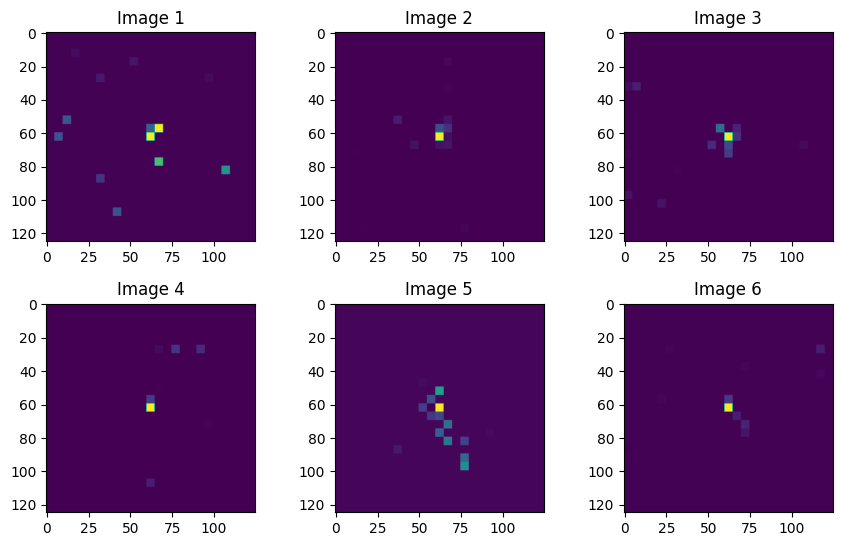

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Loop over the axes and image ids, and plot each image on a separate subplot
for i, ax in enumerate(axes.flatten()):
    image = data['X_jets'][i][2,:,:]
    ax.imshow(image)
    ax.set_title(f'Image {i+1}')
    
# Adjust spacing between subplots
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)

# Show the plot
plt.show()

In [6]:
data.columns

Index(['X_jets', 'pt', 'm0', 'y'], dtype='object')

In [7]:
# data['y']

### Creating the dataset Class

In [8]:
class task2Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Assuming 'X_jets' column contains paths to images or actual image data
        X = self.dataframe.iloc[idx]['X_jets']
        mean = X.mean(axis=(0, 1, 2), keepdims=True)
        std = X.std(axis=(0, 1, 2), keepdims=True)

        # Normalize each channel separately
        X = (X - mean) / std
        y = self.dataframe.iloc[idx]['y']
        
        if self.transform:
            X = self.transform(X)
        
        # Convert X and y to PyTorch tensors
        X_tensor = torch.tensor(X, dtype=torch.float)
        y_tensor = torch.tensor(y, dtype=torch.long)

        return X_tensor, y_tensor


### Feeding the dataset into the dataloader 

In [9]:
jet_dataset = task2Dataset(dataframe=data)


train_dataset, val_dataset = train_test_split(jet_dataset, test_size=0.2, random_state=42)


train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=256, shuffle=False)

In [10]:
next(iter(train_loader))[0].shape

torch.Size([256, 3, 125, 125])

### A model class which is having VGG based architecture ie all the convolution kernels having the filter size if the shape 3*3

In [11]:
class VGG12(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG12, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 3 * 3, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 512),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = nn.functional.adaptive_avg_pool2d(x, (3, 3))
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Create the model
model = VGG12(num_classes=2)
print(model)

VGG12(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (18): ReLU(inplace=True)


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [13]:
num_epochs = 14
train_losses, val_losses, val_accuracies = [], [], []
best_loss = 100000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train] Loss: 0.0000", leave=False)
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        train_bar.set_description(f"Epoch {epoch+1}/{num_epochs} [Train] Loss: {loss.item():.4f}")
    
    #scheduler.step()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val] Loss: 0.0000, Acc: 0.0000", leave=True)
    with torch.no_grad():
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
            
            val_bar.set_description(f"Epoch {epoch+1}/{num_epochs} [Val] Loss: {loss.item():.4f}, Acc: {correct_predictions/total_predictions:.4f}")
    
    epoch_val_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    best_loss = min(epoch_val_loss , best_loss)
    if(best_loss == epoch_val_loss):
        
        torch.save(model.state_dict(), f'model_weights{epoch}.pth')
        
    
    epoch_val_accuracy = correct_predictions / total_predictions
    val_accuracies.append(epoch_val_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")


Epoch 1/14 [Val] Loss: 0.6920, Acc: 0.6520: 100%|██████████| 5/5 [00:00<00:00,  6.78it/s]


Epoch 1/14, Train Loss: 0.6886, Val Loss: 0.6918, Val Accuracy: 0.6520


Epoch 2/14 [Val] Loss: 0.6851, Acc: 0.6179: 100%|██████████| 5/5 [00:00<00:00,  7.25it/s]


Epoch 2/14, Train Loss: 0.6830, Val Loss: 0.6803, Val Accuracy: 0.6179


Epoch 3/14 [Val] Loss: 0.6074, Acc: 0.7130: 100%|██████████| 5/5 [00:00<00:00,  7.41it/s]


Epoch 3/14, Train Loss: 0.6400, Val Loss: 0.5769, Val Accuracy: 0.7130


Epoch 4/14 [Val] Loss: 0.6258, Acc: 0.7229: 100%|██████████| 5/5 [00:00<00:00,  7.43it/s]


Epoch 4/14, Train Loss: 0.5923, Val Loss: 0.5858, Val Accuracy: 0.7229


Epoch 5/14 [Val] Loss: 0.6070, Acc: 0.7229: 100%|██████████| 5/5 [00:00<00:00,  7.37it/s]


Epoch 5/14, Train Loss: 0.5829, Val Loss: 0.5694, Val Accuracy: 0.7229


Epoch 6/14 [Val] Loss: 0.6214, Acc: 0.6978: 100%|██████████| 5/5 [00:00<00:00,  7.40it/s]


Epoch 6/14, Train Loss: 0.5750, Val Loss: 0.5831, Val Accuracy: 0.6978


Epoch 7/14 [Val] Loss: 0.6137, Acc: 0.6996: 100%|██████████| 5/5 [00:00<00:00,  7.42it/s]


Epoch 7/14, Train Loss: 0.5693, Val Loss: 0.5731, Val Accuracy: 0.6996


Epoch 8/14 [Val] Loss: 0.6031, Acc: 0.7256: 100%|██████████| 5/5 [00:00<00:00,  7.34it/s]


Epoch 8/14, Train Loss: 0.5513, Val Loss: 0.5729, Val Accuracy: 0.7256


Epoch 9/14 [Val] Loss: 0.5973, Acc: 0.7121: 100%|██████████| 5/5 [00:00<00:00,  7.36it/s]


Epoch 9/14, Train Loss: 0.5423, Val Loss: 0.5669, Val Accuracy: 0.7121


Epoch 10/14 [Val] Loss: 0.5984, Acc: 0.7229: 100%|██████████| 5/5 [00:00<00:00,  7.33it/s]


Epoch 10/14, Train Loss: 0.5425, Val Loss: 0.5877, Val Accuracy: 0.7229


Epoch 11/14 [Val] Loss: 0.6000, Acc: 0.7256: 100%|██████████| 5/5 [00:00<00:00,  7.43it/s]


Epoch 11/14, Train Loss: 0.5454, Val Loss: 0.5913, Val Accuracy: 0.7256


Epoch 12/14 [Val] Loss: 0.6306, Acc: 0.7112: 100%|██████████| 5/5 [00:00<00:00,  7.30it/s]


Epoch 12/14, Train Loss: 0.5314, Val Loss: 0.5768, Val Accuracy: 0.7112


Epoch 13/14 [Val] Loss: 0.6120, Acc: 0.7157: 100%|██████████| 5/5 [00:00<00:00,  7.32it/s]


Epoch 13/14, Train Loss: 0.5191, Val Loss: 0.5748, Val Accuracy: 0.7157


Epoch 14/14 [Val] Loss: 0.6134, Acc: 0.7202: 100%|██████████| 5/5 [00:00<00:00,  7.34it/s]

Epoch 14/14, Train Loss: 0.5258, Val Loss: 0.5746, Val Accuracy: 0.7202


In [14]:
torch.save(model.state_dict(), 'model_weights.pth')

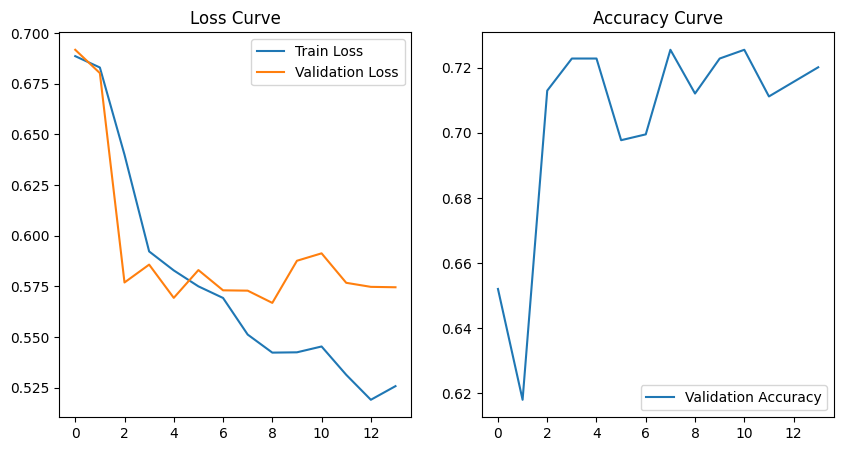

In [15]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()
